Initiation à Pytorch : Multilayer perceptron
============================

La plupart de ces notebooks peuvent tourner sans acceleration GPU. Vous pouvez utiliser Google Colab ou installer jupyter-notebook sur votre ordinateur. Pytorch est déjà installé sur Colab, par contre il faut suivre https://pytorch.org/get-started/locally/ en local.


In [1]:
## example de deploiement local
# virtualenv -ppython3.8 pstaln-env
# source pstaln-env/bin/activate
# pip3 install torch==1.10.0+cpu -f https://download.pytorch.org/whl/cpu/torch_stable.html
# pip3 install matplotlib ipykernel
# python3 -m ipykernel install --user --name=pstaln-env
# jupyter-notebook
## puis sélectionner le noyeau pstaln-evn

On commence par importer les sous-modules de pytorch.
- `torch` rassemble les fonctions de création de tenseurs et les opérations sur les tenseurs
- `torch.nn` rassemble les couches de réseau de neurones
- `torch.nn.functional` rassemble des fonctions (d'activation, de loss, etc) à utiliser dans les couches de réseaux de neurones
- `torch.optim` contient les optimiseurs pour l'apprentissage


In [2]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
print("Working with GPU : {}".format(torch.cuda.is_available()))

Working with GPU : False


Nous allons générer des points dans le plan dans l'intervalle $[-1.5, 1.5]\times[-1.5,1.5]$.

La fonction `torch.rand()` renvoie un tenseur de taille les dimensions passées en paramètres, contenant des nombres aléatoires entre 0 et 1.

Comme dans numpy, `X[:10]` renvoie les 10 premières lignes du tenseur. Il existe d'autres operations pour récupérer des sous-tenseurs, ou des scalaires.

In [3]:
n = 1000
X = torch.rand(n, 2) * 3 - 1.5

print(type(X))
print(X[:10]) # 10 elements
print(X[0]) # first row
print(X[:,0][:10]) # first column, first 10 rows
print(X[:10,0])
print(X[0,1]) # element at a given location

<class 'torch.Tensor'>
tensor([[-1.4778, -0.1684],
        [ 0.4649,  0.1308],
        [-0.4163,  1.4841],
        [ 1.3264,  0.5001],
        [ 0.8996,  0.1540],
        [ 1.4852, -0.0120],
        [-0.7534,  0.1603],
        [-1.2869,  1.0899],
        [ 0.0575, -0.4624],
        [-1.2362, -0.0285]])
tensor([-1.4778, -0.1684])
tensor([-1.4778,  0.4649, -0.4163,  1.3264,  0.8996,  1.4852, -0.7534, -1.2869,
         0.0575, -1.2362])
tensor([-1.4778,  0.4649, -0.4163,  1.3264,  0.8996,  1.4852, -0.7534, -1.2869,
         0.0575, -1.2362])
tensor(-0.1684)


`X.size()` et `X.shape` renvoient les dimensions d'un tenseur sous la forme d'un n-uplet `torch.Size`

In [4]:
print(X.size())
print(X.size(0))
print(X.shape)
print(X.shape[1])

torch.Size([1000, 2])
1000
torch.Size([1000, 2])
2


Le problème que nous souhaitons résoudre est un problème simple : un point est-il dans le disque centré sur l'origine, de rayon 1 ?

Un exemple $x$ aura pour étiquette 1 si $x_0^2 + x_1^2 < 1$, 0 sinon.

Nous créons donc un tenseur `Y` contenant ces étiquettes. Comme une condition sur un tenseur renvoie un tenseur de type `BoolTensor`, nous devons le convertir en `LongTensor` (entiers) qui est la représentation de base des étiquettes à prédire dans pytorch.

In [5]:
Y = X[:,0] ** 2 + X[:,1] ** 2 < 1
print(Y[:10])
print(Y.type())
Y = Y.long()
print(Y[:10])
print(Y.type())

tensor([False,  True, False, False,  True, False,  True, False,  True, False])
torch.BoolTensor
tensor([0, 1, 0, 0, 1, 0, 1, 0, 1, 0])
torch.LongTensor


On peut ensuite afficher le résultat avec matplotlib. `plt.scatter` prend pour arguments un vecteur d'abscices (la première colonne de X), un vecteur d'ordonnées (la 2ième colonne de X) et un vecteur de valeurs/classes pour les couleurs.

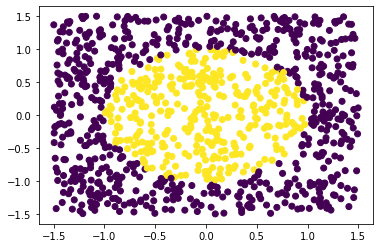

In [6]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

Nous allons maintenant entraîner un modèle linéaire pour résoudre ce problème. Pour cela, nous devons étendre la classe `nn.Module`. Ce modèle contient une couche linéaire (`nn.Linear`) qui fait une transformation affine de ses entrées:

$\hat{y} = W x  + b$

Les deux paramètres du constructeur de `nn.Linear` sont le nombre de dimensions d'un vecteur d'entrée (2 dans le plan) et la dimension du vecteur de sortie (2 étiquettes possibles). Celui-ci s'occupe d'initialiser les poids de la matrice `W` et du vecteur de biais `b` de manière aléatoire.

Notre classe doit appeler le constructeur de la classe dont elle dépend. Elle a une fonction `forward` qui est appelée lorsque l'on veut calculer la sortie du réseau pour une instance donnée.

In [7]:
class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(2, 2)
    def forward(self, x):
        return self.layer1(x)

# dans ce cas, model = nn.Linear(2, 2) est identique à notre modèle, 
# mais nous créons la classe pour pouvoir l'étendre ci-dessous
model = LinearModel()
model

LinearModel(
  (layer1): Linear(in_features=2, out_features=2, bias=True)
)

<!--Une fois un modèle instancié, on peut l'appeler sur un exemple sans passer explicitement par `forward`. Il est indispensable d'inclure le tenseur d'entrée dans une `Variable`. C'est cette classe qui s'occupe de garder la trace des opérations executées pour pouvoir ensuite calculer automatiquement le gradient lors de l'apprentissage des paramètres $W$ et $b$.-->

Le résultat est une transformation aléatoire de l'entrée, puisque les paramètres de la transformation ont été initialisés aléatoirement. Vous remarquerez que le paramètre `grad_fn` est ajouté au résultat pour indiquer quelle est la fonction à appliquer lors de la backpropagation. Dans les dernières versions de `pytorch`, cela se fait automatiquement lors d'une transformation, il n'est plus nécessaire d'envelopper les entrées dans des `Variable`s.

In [8]:
print(X[0])
model(X[0])

tensor([-1.4778, -0.1684])


tensor([-0.4127, -0.5209], grad_fn=<AddBackward0>)

On peut facilement récupérer la valeur des paramètres du modèle.

In [9]:
print(model.layer1.weight)
print(model.layer1.bias)

Parameter containing:
tensor([[ 0.0129,  0.4779],
        [ 0.1166, -0.3259]], requires_grad=True)
Parameter containing:
tensor([-0.3132, -0.4034], requires_grad=True)


Il est important qu'un modèle puisse traiter plusieurs exemples à la fois. On parle de batch. Un batch est un tenseur regroupant plusieurs exemples qui seront traités en parallèle par les différentes opérations matricielles. Les batches sont indispensables pour la vitesse d'exécution mais aussi parce qu'ils permettent de régulariser l'optimisation du gradient (on optimise la fonction en direction du gradient **moyen** d'un batch et non pas exemple par exemple).

Par convention, la première dimension d'un tenseur est la taille du batch, par exemple, des batches de taille 3.

In [10]:
print(X[:3])
model(X[:3])

tensor([[-1.4778, -0.1684],
        [ 0.4649,  0.1308],
        [-0.4163,  1.4841]])


tensor([[-0.4127, -0.5209],
        [-0.2446, -0.3918],
        [ 0.3907, -0.9355]], grad_fn=<AddmmBackward0>)

Pour l'entrainement, nous allons devoir parcourir les données d'entraînement batch par batch, en mélangeant les exemples à chaque époque. Pytorch offre des classes qui font ce travail et gèrent le cas relativement faciles où toutes les données d'entraînement sont dans un tenseur. Il existe d'autres cas où le chargement des données est moins simple (par exemple, pour des phrases de longueurs différentes). 

In [11]:
from torch.utils.data import TensorDataset, DataLoader
train_set = TensorDataset(X, Y)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)

Nous allons créer une fonction qui entraîne un modèle par descente de gradient.

Cette fonction repose sur une fonction de coût ainsi qu'un algorithme d'optimisation. Pour la fonction de coût, nous utiliserons `CrossEntropyLoss` qui calcule l'entropie croisée entre la distribution produite par le système et les étiquettes de référence. Dans pytorch, cette fonction inclut le `softmax` qui s'assure que les scores soient entre 0 et 1, donc il faut bien éviter de l'appeler en fin d'inférence dans le modèle. Nous utiliserons ici l'optimiseur `Adam` qui converge plus rapidement que `SGD` (le gradient stochastique classique) grâce à un learning rate adaptatif. Son seul inconvénent est qu'il utilise plus de mémoire que `SGD`, ce qui peut poser problème sur GPU. 

La boucle d'entrainement fait plusieurs époques (passages sur toutes les données), où l'on parcourt les données batch par batch (ce que fait le `train_loader`).

Pour chaque batch, il faut remettre à zéro l'accumulateur de gradient, calculer les sorties du modèles, puis la fonction de loss entre les scores prédits et les étiquettes de référence.

On appelle `loss.backward()` pour calculer le gradient par back-propagation et `optimizer.step()` pour appliquer le gradient au modèle.

In [12]:
def fit(model, epochs, train_loader):
    criterion = nn.CrossEntropyLoss()           # fonction de loss à appliquer
    optimizer = optim.Adam(model.parameters())
    for epoch in range(epochs):                 # parcourir l'ensemble d'entraînement `epoch` fois
        total_loss = 0                          # loss (moyenne) de l'itération
        num = 0
        for x, y in train_loader:               # charge un batch
            optimizer.zero_grad()               # par défault, le gradient est cumulatif
            y_scores = model(x)                 # prédictions (forward) avec paramètres actuels
            loss = criterion(y_scores, y)       # différence entre scores prédits et référence (inclut softmax)
            loss.backward()                     # calcule le gradient
            optimizer.step()                    # applique le gradient au modèle
            total_loss += loss.item()           # loss cumulée (pour affichage)
            num += len(y)                       # nombre d'exemples traités
        if epoch % (epochs // 10) == 0:         # affiche loss toutes les (itérations/10) itérations
            print(epoch, total_loss / num)

Nous pouvons entraîner le modèle sur 50 époques. Chaque époque lit la totalité des 1000 points en entrée par batchs de taille 4, calcule les prédictions, et ajuste les paramètres selon le gradient de la loss.

In [13]:
fit(model, 50, train_loader)

0 0.17794651743769646
5 0.162335816770792
10 0.16210858523845673
15 0.16211456376314162
20 0.16212866687774657
25 0.1621002486348152
30 0.16209445095062255
35 0.16210922762751578
40 0.16211508616805076
45 0.16211527451872826


On observe que la loss moyenne sur les données d'entraînement descend mais converge très vite.

On peut maintenant produire un ensemble de validation indépendant `X_val` et appliquer la transformation apprise sur ces nouvelles données pour calculer des scores `Y_score` (de dimension 2). La décision de ce modèle est l'étiquette pour laquelle le score est maximal (`Y_score[0]>Y_score[1]` alors la prédiction est `0`, sinon la prédiction vaut `1`). La fonction `torch.max`, appliquée sur les lignes de la matrice `Y_score`, renvoie deux éléments : le vecteur des maximums, et le vecteur de indices des maximums. C'est ce dernier qui nous intéresse et que nous allons afficher. Le deuxième paramètre indique la dimension sur laquelle le maximum sera calculé (ici, `1` pour le maximum sur les colonnes).

Il est fort probable que le classifieur prédise toujours la même étiquette, ce qui se traduit par une couleur de points uniformes. Au mieux, l'espace sera divisé en deux par le separateur linéaire appris par le modèle (vous pouvez observer cela avec un modèle aléatoire avant d'appeler `fit`). Clairement, un modèle linéaire n'est pas capable de discriminer les points à l'interieur d'un cercle. 

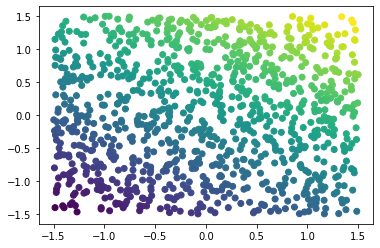

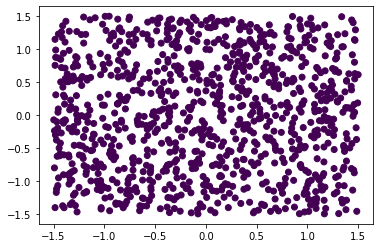

In [20]:
X_val = torch.rand(n, 2) * 3 - 1.5
Y_score = model(X_val)
Y_pred = torch.max(Y_score, 1)[1]

plt.scatter(X_val[:,0], X_val[:,1], c=Y_score[:,0].data) # Values closer to zero shown in darker color
plt.show()

plt.scatter(X_val[:,0], X_val[:,1], c=Y_pred) # Most of the time, predicts only zeros
plt.show()

Afin d'obtenir un meilleur classifieur, nous allons maintenant faire un perceptron multicouches (MLP) avec une fonction d'activation non linéaire.

$\hat{y} = W_2  \times tanh(W_1 x + b_1) + b_2$

Ce modèle a deux couches linéaires, la première projetant les entrées dans un espace de 10 dimensions ($W_1$ est de dimensions $2\times 10$). Elle est suivie d'une fonction d'activation $tanh$ pour rendre le modèle non linéaire (la composition de fonctions linéaires serait elle même linéaire), et d'une seconde projection dans un espace de 2 dimensions pour les deux étiquettes à prédire.

In [15]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self): # le constructeur de la classe déclare les couches
        super().__init__()
        self.layer1 = nn.Linear(2, 10)
        self.layer2 = nn.Linear(10, 2)
    def forward(self, x):  # la fonction forward combine les couches déclarées
        return self.layer2(torch.tanh(self.layer1(x)))

mlp = MultiLayerPerceptron()
mlp

MultiLayerPerceptron(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=2, bias=True)
)

On peut alors entraîner ce modèle à l'aide de la fonction `fit`, et le loss baisse considérablement plus vite.

In [16]:
fit(mlp, 50, train_loader)

0 0.16712462314963342
5 0.15389345934987067
10 0.13049309220910071
15 0.10257390373945237
20 0.08032219697535038
25 0.06647996072098612
30 0.057195376191288234
35 0.050607411064207554
40 0.04603676991537213
45 0.042261421885341405


De la même manière, on peut produire les scores et les décisions pour le même ensemble de validation. La surface de décision produite est beaucoup plus pertinente. 

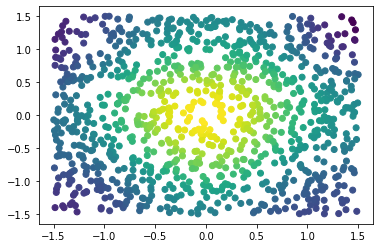

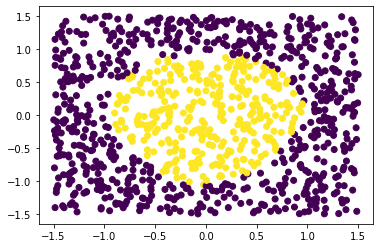

In [21]:
Y_score = mlp(X_val)
Y_pred = torch.max(Y_score, 1)[1]

plt.scatter(X_val[:,0], X_val[:,1], c=Y_score[:,1].data) # higher values (lighter color) -> more likely to predict 1
plt.show()

plt.scatter(X_val[:,0], X_val[:,1], c=Y_pred)
plt.show()

On peut observer que les prédictions sont pratiquement identiques aux étiquettes de référence pour l'ensemble de validation. On peut calculer l'exactitude des prédictions comme étant la proportion de prédictions correctes parmi les prédictions effectuées. Pour pouvoir calculer cela, il faut d'abord calculer `Y_val` les étiquettes de référence pour le jeu de données de validation `X_val` (nous l'avons fait auparavant uniquement pour le jeu d'entraînement `X`).

In [18]:
Y_val = X_val[:,0] ** 2 + X_val[:,1] ** 2 < 1
n_errors = sum(abs(Y_val.long() - Y_pred))
accuracy =  (n - n_errors) / n
print("Accuracy : {}".format(accuracy))

Accuracy : 0.9639999866485596


Essayez d'entraîner davantage le modèle (appelez `fit` sur 50 époques supplémentaires) et voyez que les prédictions sont meilleures, avec une exactitude qui augmente jusqu'à un certain seuil.

Exercice
---------

Prenons un problème un peu plus difficile: les points à reconnaître appartiennent maintenant à deux cercles séparés dans le plan :
$$y = (2 x_0 - \frac{3}{2})^2 + x_1^2 < \frac{1}{2} \vee (2 x_0 + \frac{3}{2})^2 + x_1^2 < \frac{1}{2}$$

* Le MLP à deux couches est-il capable de résoudre ce problème ? 
* Qu'en serait-il d'un MLP à trois couches ? 
* Et si on change les dimensions des chouches cachées ? 
* Et que se passe-t-il si on change la fonction d'activation pour utiliser des ReLU (`F.relu`) ?

Voici le travail à effectuer (à titre indicatif) :
1. générer des étiquettes $Y$ pour $X$ selon l'équation donnée ci-dessus (l'opérateur $\vee$ signifie un "ou" logique entre ses arguments, et peut être appliqué à deux matrices booléennes grâce à l'opérateur `|`), afficher ces nouvelles étiquettes
2. recréer un `DataLoader` à partir des nouvelles données
3. réinstancier un MLP et l'entraîner sur ces données
4. afficher la surface de décision correspondante
5. créer une nouvelle classe de modèle avec une couche supplémentaire et la tester
6. remplacer la fonction d'activation `F.tanh` par `F.relu`